### Introduction

This notebook contains my code for Assignment 4.

In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir("D:\\Datasets\\Lending_Club_Datasets")

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from packaging import version
from collections import Counter
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
import tensorflow_datasets as tfds

import shap

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
print("Keras version: ", keras.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.5.0
Keras version:  2.5.0


#### Load in the Data Here

We will be using Lending Club data in this example, so let's examine the dataset.

In [2]:
loan_data = pd.read_csv("loan.csv")
loan_data.head(10)

D:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
6,1069639,1304742,7000,7000,7000.0,60 months,15.96%,170.08,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,E,E1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
8,1071795,1306957,5600,5600,5600.0,60 months,21.28%,152.39,F,F2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
9,1071570,1306721,5375,5375,5350.0,60 months,12.69%,121.45,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Based on a first glance, there are numerous columns that are missing; let's take a closer look:

In [3]:
lc_profile = ProfileReport(loan_data, title="Lending Club 1st Pass", explorative=True)
lc_profile.to_file("Lending_Club_Pass_1.html")

Summarize dataset:   0%|          | 0/124 [00:00<?, ?it/s]

D:\Anaconda\envs\tensorflow\lib\site-packages\missingno\missingno.py:250: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=fontsize)
D:\Anaconda\envs\tensorflow\lib\site-packages\pandas_profiling\model\summary.py:194: UserWarning: There was an attempt to generate the bar missing values diagrams, but this failed.
    To hide this warning, disable the calculation
    (using `df.profile_report(missing_diagrams={"bar": False}`)
    If this is problematic for your use case, please report this as an issue:
    https://github.com/pandas-profiling/pandas-profiling/issues
    (include the error message: 'The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (111).')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The last 10 - 15 columns need to be removed as they contain missing values or constant values. (Refer to the List of Removed Columns file.)

In [4]:
loan_data_2 = pd.read_csv("loan_2.csv")
loan_data_2

D:\Anaconda\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5000.00,863.16,0.00,0.00,0.00,15-Jan,171.62,NaN,16-May,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,456.46,435.17,0.00,117.08,1.11,13-Apr,119.66,NaN,13-Sep,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,2400.00,605.67,0.00,0.00,0.00,14-Jun,649.91,NaN,16-May,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,10000.00,2214.92,16.97,0.00,0.00,15-Jan,357.48,NaN,16-Apr,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,2475.94,1037.39,0.00,0.00,0.00,16-May,67.79,16-Jun,16-May,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,...,2500.00,322.97,0.00,0.00,0.00,10-Jul,80.90,NaN,10-Jun,NaN
39713,90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,...,8500.00,1413.49,0.00,0.00,0.00,10-Jul,281.94,NaN,10-Jul,NaN
39714,90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,...,5000.00,272.16,0.00,0.00,0.00,8-Apr,0.00,NaN,7-Jun,NaN
39715,90376,89243,5000,5000,650.0,36 months,7.43%,155.38,A,A2,...,5000.00,174.20,0.00,0.00,0.00,8-Jan,0.00,NaN,7-Jun,NaN


This has reduced the dataset down to 48 columns. Let's re-run the Pandas Profiling report.

In [5]:
lc2_profile = ProfileReport(loan_data_2, title="Lending Club 2nd Pass", explorative=True)
lc2_profile.to_file("Lending_Club_Pass_2.html")

Summarize dataset:   0%|          | 0/61 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Cleaning the Dataset:

Set id and member_id to index columns.<br>

Some columns are target leakage columns since they provide information that would not be known at the time of origination, so drop them. There are also ambiguous columns (Ex. last_credit_pull_d) that are unclear based on the data provided.

We do not the know the fate of "Current" borrowers, so we will remove these from our analysis.

Get the list of numeric and categorical variables.

Numerics:<br>
- Impute Missing Values
- Check if there are any questionable values

Categoricals: <br>
- Impute Missing Values to "MISSING"
- Check the cardinality to see how many different categories are in the data.

In [6]:
# Set the id and member_id to index columns. Drop leakage columns as well.

loan_data_3 = loan_data_2.set_index(['id', 'member_id'])
loan_data_3.drop(columns=['total_pymnt',
                          'total_pymnt_inv',
                          'total_rec_int',
                          'total_rec_late_fee',
                          'total_rec_prncp',
                          'initial_list_status',
                          'issue_d',
                          'recoveries',
                          'title',
                          'out_prncp',
                          'out_prncp_inv',
                          'collection_recovery_fee',
                          'last_pymnt_d',
                          'last_pymnt_amnt',
                          'next_pymnt_d',
                          'last_credit_pull_d',
                          'pymnt_plan'], inplace=True)
loan_data_3
loan_data_3.columns

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,Credit_History_Months,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
id,member_id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,440,1,NaN,NaN,3,0,13648,83.70%,9,0.0
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,269,5,NaN,NaN,3,0,1687,9.40%,4,0.0
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,-2,2,NaN,NaN,2,0,2956,98.50%,10,0.0
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,307,1,35.0,NaN,10,0,5598,21%,37,0.0
1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,308,0,38.0,NaN,15,0,27783,53.90%,38,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,FiSite Research,4 years,...,370,0,0.0,0.0,13,0,7274,13.10%,40,NaN
90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,"Squarewave Solutions, Ltd.",3 years,...,417,1,5.0,0.0,6,0,8847,26.90%,9,NaN
90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,NaN,< 1 year,...,275,0,0.0,0.0,11,0,9698,19.40%,20,NaN


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'Credit_History_Months', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [7]:
# Removing the "Current" borrowers

loan_data_3['loan_status'].unique()
loan_data_3['loan_status'].value_counts()
loan_data_4 = pd.DataFrame(loan_data_3.loc[loan_data_3['loan_status'] != 'Current'])
loan_data_4['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current'], dtype=object)

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

array(['Fully Paid', 'Charged Off'], dtype=object)

In [8]:
lc3_profile = ProfileReport(loan_data_4, title="Lending Club 3rd Pass", explorative=True)
lc3_profile.to_file("Lending_Club_Pass_3.html")

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
loan_data_4

,,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,Credit_History_Months,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies
id,member_id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,440,1,NaN,NaN,3,0,13648,83.70%,9,0.0
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,269,5,NaN,NaN,3,0,1687,9.40%,4,0.0
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,-2,2,NaN,NaN,2,0,2956,98.50%,10,0.0
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,307,1,35.0,NaN,10,0,5598,21%,37,0.0
1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,A,A4,Veolia Transportaton,3 years,...,-2,3,NaN,NaN,9,0,7963,28.30%,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,FiSite Research,4 years,...,370,0,0.0,0.0,13,0,7274,13.10%,40,NaN
90665,90607,8500,8500,875.0,36 months,10.28%,275.38,C,C1,"Squarewave Solutions, Ltd.",3 years,...,417,1,5.0,0.0,6,0,8847,26.90%,9,NaN
90395,90390,5000,5000,1325.0,36 months,8.07%,156.84,A,A4,NaN,< 1 year,...,275,0,0.0,0.0,11,0,9698,19.40%,20,NaN


In [11]:
loan_data_4.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                  2386
emp_length                 1033
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
Credit_History_Months         0
inq_last_6mths                0
mths_since_last_delinq    24905
mths_since_last_record    35837
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
pub_rec_bankruptcies        697
dtype: int64

In [12]:
# Impute the median value for missing numerics:

loan_data_4['mths_since_last_delinq'].fillna(loan_data_4['mths_since_last_delinq'].median(), inplace=True)
loan_data_4['mths_since_last_record'].fillna(loan_data_4['mths_since_last_record'].median(), inplace=True)
loan_data_4['pub_rec_bankruptcies'].fillna(loan_data_4['pub_rec_bankruptcies'].median(), inplace=True)

# Impute with "MISSING" for the following categoricals:

loan_data_4['emp_title'].fillna('MISSING', inplace=True)
loan_data_4['emp_length'].fillna('MISSING', inplace=True)


#### Convert Percentages to Numbers

These percentages were read in as strings, and should be converted to numbers.

In [13]:
loan_data_4['int_rate'] = loan_data_4['int_rate'].str.replace('%', '')
loan_data_4['int_rate']

id       member_id
1077501  1296599      10.65
1077430  1314167      15.27
1077175  1313524      15.96
1076863  1277178      13.49
1075269  1311441       7.90
                      ...  
92187    92174         8.07
90665    90607        10.28
90395    90390         8.07
90376    89243         7.43
87023    86999        13.75
Name: int_rate, Length: 38577, dtype: object

In [14]:
loan_data_4['revol_util'] = loan_data_4['revol_util'].str.replace('%', '')
loan_data_4['revol_util']

id       member_id
1077501  1296599      83.70
1077430  1314167       9.40
1077175  1313524      98.50
1076863  1277178         21
1075269  1311441      28.30
                      ...  
92187    92174        13.10
90665    90607        26.90
90395    90390        19.40
90376    89243         0.70
87023    86999        51.50
Name: revol_util, Length: 38577, dtype: object

In [15]:
# Revolving Utilization

loan_data_4['revol_util'].fillna(loan_data_4['revol_util'].median(), inplace=True)

#### Check Null Values and Column Types

Let's check the null values to ensure that we captured all of them here:

In [16]:
loan_data_4.isna().sum()

loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_title                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
zip_code                  0
addr_state                0
dti                       0
delinq_2yrs               0
Credit_History_Months     0
inq_last_6mths            0
mths_since_last_delinq    0
mths_since_last_record    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
pub_rec_bankruptcies      0
dtype: int64

In [17]:
loan_data_4.dtypes

loan_amnt                   int64
funded_amnt                 int64
funded_amnt_inv           float64
term                       object
int_rate                   object
installment               float64
grade                      object
sub_grade                  object
emp_title                  object
emp_length                 object
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
zip_code                   object
addr_state                 object
dti                       float64
delinq_2yrs                 int64
Credit_History_Months       int64
inq_last_6mths              int64
mths_since_last_delinq    float64
mths_since_last_record    float64
open_acc                    int64
pub_rec                     int64
revol_bal                   int64
revol_util                 object
total_acc                   int64
pub_rec_bankruptcies      float64
dtype: object

#### Preparing Data for Modeling

The data needs to be encoded and scaled for use in a deep learning model.

In [2]:
# loan_data_clean.to_csv("loan_data_clean.csv")
loan_data_clean = pd.read_csv("loan_data_clean.csv")
# loan_data_clean['loan_status'] = loan_data_clean['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
loan_data_clean['revol_util'] = loan_data_clean['revol_util'].astype(np.float32)
loan_data_clean['int_rate'] = loan_data_clean['int_rate'].astype(np.float32)
loan_data_clean.set_index(['id', 'member_id'], inplace=True)
loan_data_clean.drop(columns=['emp_title'], inplace=True)

numeric_features = ['loan_amnt',
                    'funded_amnt',
                    'funded_amnt_inv',
                    'int_rate',
                    'installment',
                    'annual_inc',
                    'dti',
                    'delinq_2yrs',
                    'Credit_History_Months',
                    'inq_last_6mths',
                    'mths_since_last_delinq',
                    'mths_since_last_record',
                    'open_acc',
                    'pub_rec',
                    'revol_bal',
                    'revol_util',
                    'total_acc',
                    'pub_rec_bankruptcies']

categorical_features = ['term',
                        'grade',
                        'sub_grade',
#                        'emp_title',
                        'emp_length',
                        'home_ownership',
                        'verification_status',
                        'purpose',
                        'zip_code',
                        'addr_state']

loan_data_m = loan_data_clean.copy(deep=True)
Y = loan_data_m['loan_status']
X = loan_data_m.drop(columns=['loan_status'])

scaler = StandardScaler()
#cat_scaler = OrdinalEncoder()
X[numeric_features] = scaler.fit_transform(X[numeric_features])
dummies = pd.get_dummies(X[categorical_features], drop_first=True)
X.drop(columns=categorical_features, inplace=True)
#loan_data_m[categorical_features] = cat_scaler.fit_transform(loan_data_m[categorical_features])
X = pd.concat([X, dummies], axis=1)

X
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
X_train
Y_train

,,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,Credit_History_Months,inq_last_6mths,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
id,member_id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,-0.822910,-0.815781,-0.747225,-0.347364,-0.764949,-0.697282,2.154558,-0.297945,1.286545,0.119701,...,0,0,0,0,0,0,0,0,0,0
1077430,1314167,-1.163122,-1.168379,-1.099657,0.904234,-1.258822,-0.603850,-1.839173,-0.297945,0.225286,3.852674,...,0,0,0,0,0,0,0,0,0,0
1077175,1313524,-1.176731,-1.182483,-1.113896,1.091161,-1.141393,-0.880222,-0.682265,-0.297945,-1.456592,1.052944,...,0,0,0,0,0,0,0,0,0,0
1076863,1277178,-0.142484,-0.110583,-0.031681,0.422017,0.080732,-0.304868,1.008140,-0.297945,0.461121,0.119701,...,0,0,0,0,0,0,0,0,0,0
1075269,1311441,-0.822910,-0.815781,-0.743665,-1.092363,-0.795672,-0.510418,-0.310616,-0.297945,-1.456592,1.986187,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92187,92174,-1.163122,-1.168379,-1.302572,-1.046309,-1.169720,0.641909,-0.291134,-0.297945,0.852112,-0.813543,...,0,0,0,0,0,0,0,0,0,0
90665,90607,-0.346612,-0.322142,-1.331051,-0.447601,-0.225686,-0.790714,-1.029937,1.733483,1.143803,0.119701,...,0,0,0,0,0,0,0,0,0,0
90395,90390,-0.822910,-0.815781,-1.266973,-1.046309,-0.793851,0.486189,-1.644357,-0.297945,0.262523,-0.813543,...,0,0,0,0,0,0,0,0,0,0


,,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,Credit_History_Months,inq_last_6mths,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
id,member_id,,,,,,,,,,,,,,,,,,,,,
599253,769115,-0.822910,-0.815781,-0.747225,-0.320273,-0.763799,0.190321,-0.812642,-0.297945,0.107369,-0.813543,...,0,0,0,0,0,0,0,0,0,0
641903,821658,-0.686825,-0.674741,-0.672466,-1.460799,-0.663625,-0.772028,-0.144273,-0.297945,1.789247,1.986187,...,0,0,0,0,0,0,0,0,0,0
370423,387286,0.061643,0.100976,-0.355020,0.161944,0.299102,-0.354761,0.395218,-0.297945,-1.462798,1.052944,...,0,0,0,0,0,0,0,0,0,0
995782,1220364,-1.367250,-1.379938,-1.313252,-1.198018,-1.396430,-0.634994,-0.159259,-0.297945,-1.431767,-0.813543,...,0,0,0,0,0,0,1,0,0,0
636387,815252,-0.142484,-0.110583,-0.109999,-1.561036,-0.083716,0.252609,0.317292,-0.297945,-1.437973,-0.813543,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466771,586588,-0.414655,-0.392662,-0.326421,0.254053,-0.255930,-0.292411,-1.194782,3.764910,1.075534,-0.813543,...,0,0,0,0,0,0,0,0,0,0
689287,879559,-0.523523,-0.505494,-0.441071,-1.157382,-0.469555,-0.712854,-1.050917,-0.297945,-1.450386,1.986187,...,0,0,0,0,0,0,0,0,0,0
590838,758895,-0.305787,-0.279831,-0.202557,1.088452,-0.520984,0.036719,0.177923,-0.297945,1.298957,-0.813543,...,0,0,0,0,0,0,0,0,0,0


id      member_id
599253  769115       0
641903  821658       0
370423  387286       0
995782  1220364      0
636387  815252       0
                    ..
466771  586588       0
689287  879559       0
590838  758895       0
439146  528555       0
535511  691951       0
Name: loan_status, Length: 30861, dtype: int64

#### Modeling

Building the Multi-layer Perceptron Models Here.

In [3]:
loan_data_clean['loan_status'].value_counts()

0    32950
1     5627
Name: loan_status, dtype: int64

In [4]:
weight_0 = 1/loan_data_clean['loan_status'].value_counts()[0]
weight_1 = 1/loan_data_clean['loan_status'].value_counts()[1]

weight_0
weight_1

3.0349013657056145e-05

0.00017771459036786921

In [5]:
def nn_1(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
#    model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
#    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10,
                       class_weight={0: weight_0, 1: weight_1})    
    return model, history

In [6]:
model_1, history_1 = nn_1(X_train, Y_train, X_test, Y_test)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
965/965 [==============================] - 5s 4ms/step - loss: 3.3318e-05 - auc: 0.6765 - val_loss: 0.6145 - val_auc: 0.7062
Epoch 2/10
965/965 [==============================] - 4s 4ms/step - loss: 3.1959e-05 - auc: 0.7166 - val_loss: 0.6225 - val_auc: 0.7126
Epoch 3/10
965/965 [==============================] - 4s 4ms/step - loss: 3.1466e-05 - auc: 0.7283 - val_loss: 0.6187 - val_auc: 0.7133
Epoch 4/10
965/965 [==============================] - 4s 4ms/step - loss: 3.1054e-05 - auc: 0.7384 - val_loss: 0.6161 - val_auc: 0.7134
Epoch 5/10
965/965 [==============================] - 4s 4ms/step - loss: 3.0645e-05 - auc: 0.7470 - val_loss: 0.6362 - val_auc: 0.7102
Epoch 6/10
965/965 [==============================] - 4s 4ms/step - loss: 3.0308e-05 - auc: 0.7543 - val_loss: 0.6089 - val_auc: 0.7088
Epoch 7/10
965/965 [==========================

In [24]:
def nn_2(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/5
965/965 [==============================] - 5s 5ms/step - loss: 3.3059e-05 - auc_2: 0.6835 - val_loss: 0.6333 - val_auc_2: 0.7082
Epoch 2/5
965/965 [==============================] - 4s 4ms/step - loss: 3.1760e-05 - auc_2: 0.7216 - val_loss: 0.5941 - val_auc_2: 0.7078
Epoch 3/5
965/965 [==============================] - 4s 4ms/step - loss: 3.1186e-05 - auc_2: 0.7350 - val_loss: 0.5448 - val_auc_2: 0.7080
Epoch 4/5
965/965 [==============================] - 4s 4ms/step - loss: 3.0802e-05 - auc_2: 0.7429 - val_loss: 0.5862 - val_auc_2: 0.7082
Epoch 5/5
965/965 [==============================] - 4s 4ms/step - loss: 3.0373e-05 - auc_2: 0.7525 - val_loss: 0.6064 - val_auc_2: 0.7054


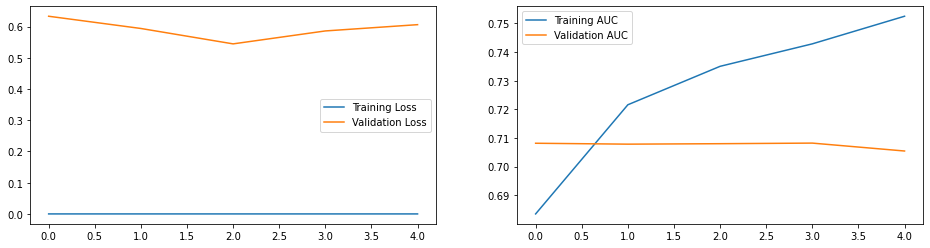

In [25]:
model_2, history_2 = nn_2(X_train, Y_train, X_test, Y_test)

In [26]:
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop

In [30]:
# Increasing the learning rate from 0.001 --> 0.002 (2x)

def nn_3(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(lr=0.002), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/30
965/965 [==============================] - 5s 4ms/step - loss: 3.3121e-05 - auc_4: 0.6807 - val_loss: 0.6513 - val_auc_4: 0.7086
Epoch 2/30
965/965 [==============================] - 4s 4ms/step - loss: 3.1782e-05 - auc_4: 0.7212 - val_loss: 0.5823 - val_auc_4: 0.7107
Epoch 3/30
965/965 [==============================] - 4s 4ms/step - loss: 3.1241e-05 - auc_4: 0.7342 - val_loss: 0.6187 - val_auc_4: 0.7099
Epoch 4/30
965/965 [==============================] - 4s 4ms/step - loss: 3.0714e-05 - auc_4: 0.7464 - val_loss: 0.6573 - val_auc_4: 0.7089
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 3.0320e-05 - auc_4: 0.7551 - val_loss: 0.6548 - val_auc_4: 0.7061


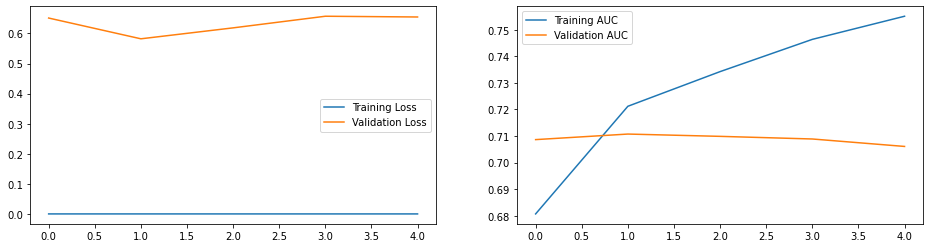

In [31]:
model_3, history_3 = nn_3(X_train, Y_train, X_test, Y_test)

In [35]:
# Increasing the learning rate from 0.002 --> 0.01

def nn_4(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(lr=0.01), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/30
965/965 [==============================] - 5s 5ms/step - loss: 3.2936e-05 - auc_6: 0.6879 - val_loss: 0.6398 - val_auc_6: 0.7088
Epoch 2/30
965/965 [==============================] - 4s 4ms/step - loss: 3.1882e-05 - auc_6: 0.7181 - val_loss: 0.6197 - val_auc_6: 0.7052
Epoch 3/30
965/965 [==============================] - 4s 4ms/step - loss: 3.1411e-05 - auc_6: 0.7293 - val_loss: 0.6098 - val_auc_6: 0.7079
Epoch 4/30
965/965 [==============================] - 4s 4ms/step - loss: 3.0973e-05 - auc_6: 0.7372 - val_loss: 0.6233 - val_auc_6: 0.7035
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 3.0631e-05 - auc_6: 0.7451 - val_loss: 0.6739 - val_auc_6: 0.6994
Epoch 6/30
965/965 [==============================] - 4s 4ms/step - loss: 3.0220e-05 - auc_6: 0.7531 - val_loss: 0.6081 - val_auc_6: 0.7053
Epoch 7/30
965/965 [==============================] - 4s 4ms/step - loss: 2.9919e-05 - auc_6: 0.7580 - val_loss: 0.5826 - val_auc_6: 0.6997
Epoch 8/30
965/965 [

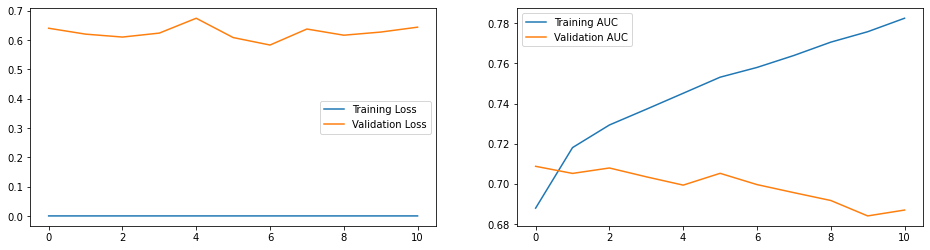

In [36]:
model_4, history_4 = nn_4(X_train, Y_train, X_test, Y_test)

In [39]:
# Changing Adam --> Nadam, keeping the default learning rate

def nn_5(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Nadam(), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/30
965/965 [==============================] - 9s 8ms/step - loss: 3.3272e-05 - auc_8: 0.6786 - val_loss: 0.6518 - val_auc_8: 0.7043
Epoch 2/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1812e-05 - auc_8: 0.7209 - val_loss: 0.6421 - val_auc_8: 0.7120
Epoch 3/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1326e-05 - auc_8: 0.7323 - val_loss: 0.6200 - val_auc_8: 0.7121
Epoch 4/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0905e-05 - auc_8: 0.7419 - val_loss: 0.6271 - val_auc_8: 0.7106
Epoch 5/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0523e-05 - auc_8: 0.7506 - val_loss: 0.6373 - val_auc_8: 0.7091
Epoch 6/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0188e-05 - auc_8: 0.7572 - val_loss: 0.6152 - val_auc_8: 0.7058
Epoch 7/30
965/965 [==============================] - 8s 8ms/step - loss: 2.9853e-05 - auc_8: 0.7640 - val_loss: 0.6030 - val_auc_8: 0.6985
Epoch 8/30
965/965 [

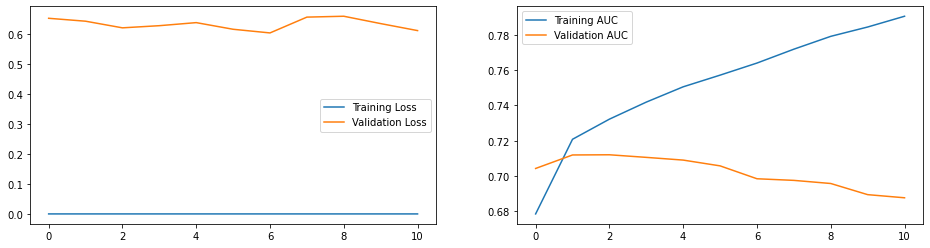

In [40]:
model_5, history_5 = nn_5(X_train, Y_train, X_test, Y_test)

In [41]:
# Changing Adam --> Nadam, increasing the learning rate to 0.002 (2x)

def nn_6(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Nadam(learning_rate=0.002), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/30
965/965 [==============================] - 9s 8ms/step - loss: 3.2804e-05 - auc_9: 0.6938 - val_loss: 0.6300 - val_auc_9: 0.7115
Epoch 2/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1648e-05 - auc_9: 0.7250 - val_loss: 0.5919 - val_auc_9: 0.7040
Epoch 3/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1103e-05 - auc_9: 0.7382 - val_loss: 0.5970 - val_auc_9: 0.7076
Epoch 4/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0702e-05 - auc_9: 0.7464 - val_loss: 0.6192 - val_auc_9: 0.7078
Epoch 5/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0287e-05 - auc_9: 0.7549 - val_loss: 0.6226 - val_auc_9: 0.7054
Epoch 6/30
965/965 [==============================] - 8s 8ms/step - loss: 2.9840e-05 - auc_9: 0.7647 - val_loss: 0.6274 - val_auc_9: 0.7001


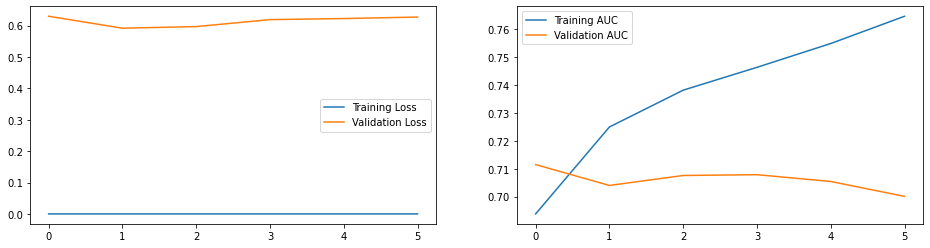

In [42]:
model_6, history_6 = nn_6(X_train, Y_train, X_test, Y_test)

In [43]:
# Changing Adam --> Nadam, increasing the learning rate to 0.01 (large increase)

def nn_7(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Nadam(learning_rate=0.01), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       class_weight={0: weight_0, 1: weight_1},
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/30
965/965 [==============================] - 9s 8ms/step - loss: 3.2763e-05 - auc_10: 0.6959 - val_loss: 0.6094 - val_auc_10: 0.7113
Epoch 2/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1749e-05 - auc_10: 0.7214 - val_loss: 0.6691 - val_auc_10: 0.7106
Epoch 3/30
965/965 [==============================] - 8s 8ms/step - loss: 3.1294e-05 - auc_10: 0.7320 - val_loss: 0.6205 - val_auc_10: 0.7083
Epoch 4/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0945e-05 - auc_10: 0.7390 - val_loss: 0.6143 - val_auc_10: 0.7044
Epoch 5/30
965/965 [==============================] - 8s 8ms/step - loss: 3.0600e-05 - auc_10: 0.7467 - val_loss: 0.6006 - val_auc_10: 0.6997
Epoch 6/30
965/965 [==============================] - 7s 8ms/step - loss: 3.0183e-05 - auc_10: 0.7547 - val_loss: 0.5776 - val_auc_10: 0.7058
Epoch 7/30
965/965 [==============================] - 8s 8ms/step - loss: 2.9767e-05 - auc_10: 0.7628 - val_loss: 0.6289 - val_auc_10: 0.7006
Epoch 

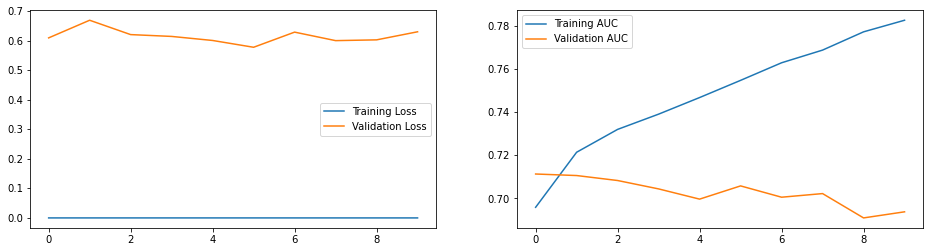

In [44]:
model_7, history_7 = nn_7(X_train, Y_train, X_test, Y_test)

In [45]:
# No weights

def nn_8(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Nadam(learning_rate=0.01), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/30
965/965 [==============================] - 9s 8ms/step - loss: 0.3903 - auc_11: 0.6826 - val_loss: 0.3959 - val_auc_11: 0.6926
Epoch 2/30
965/965 [==============================] - 8s 8ms/step - loss: 0.3763 - auc_11: 0.7196 - val_loss: 0.3925 - val_auc_11: 0.6977
Epoch 3/30
965/965 [==============================] - 8s 8ms/step - loss: 0.3696 - auc_11: 0.7358 - val_loss: 0.3937 - val_auc_11: 0.6879
Epoch 4/30
965/965 [==============================] - 7s 8ms/step - loss: 0.3644 - auc_11: 0.7465 - val_loss: 0.4005 - val_auc_11: 0.6845
Epoch 5/30
965/965 [==============================] - 7s 8ms/step - loss: 0.3574 - auc_11: 0.7588 - val_loss: 0.4060 - val_auc_11: 0.6786
Epoch 6/30
965/965 [==============================] - 8s 8ms/step - loss: 0.3502 - auc_11: 0.7725 - val_loss: 0.4198 - val_auc_11: 0.6678


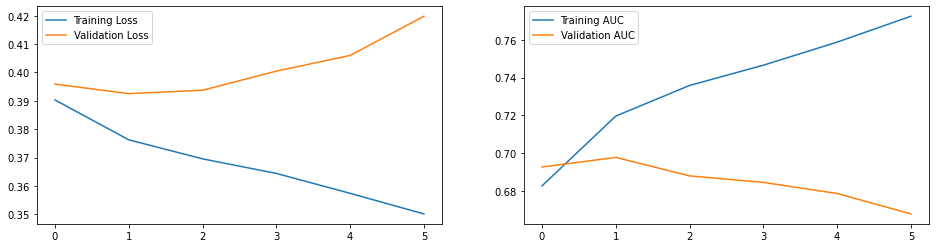

In [46]:
model_8, history_8 = nn_8(X_train, Y_train, X_test, Y_test)

In [51]:
# No Weights - Testing Adam with default learning rate
# Overfitting detected - try testing network sizes

def nn_9(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()
     
    return model, history

Epoch 1/30
965/965 [==============================] - 5s 4ms/step - loss: 0.4070 - auc_14: 0.6514 - val_loss: 0.3895 - val_auc_14: 0.7011
Epoch 2/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3746 - auc_14: 0.7230 - val_loss: 0.3897 - val_auc_14: 0.7006
Epoch 3/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3690 - auc_14: 0.7367 - val_loss: 0.3895 - val_auc_14: 0.7015
Epoch 4/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3638 - auc_14: 0.7476 - val_loss: 0.3919 - val_auc_14: 0.6974
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3590 - auc_14: 0.7577 - val_loss: 0.3960 - val_auc_14: 0.6949
Epoch 6/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3543 - auc_14: 0.7661 - val_loss: 0.3997 - val_auc_14: 0.6851
Epoch 7/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3497 - auc_14: 0.7743 - val_loss: 0.4037 - val_auc_14: 0.6822
Epoch 8/30
965/965 [==============

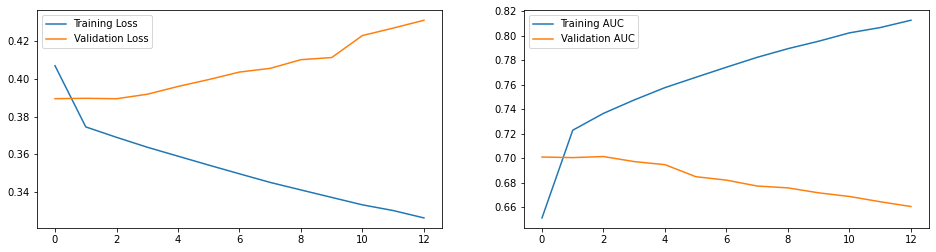

In [52]:
model_9, history_9 = nn_9(X_train, Y_train, X_test, Y_test)

In [54]:
# Changing the network structure - adding in Dropout = 0.2

def nn_10(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(10,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 5s 5ms/step - loss: 0.4827 - auc_15: 0.5583 - val_loss: 0.3942 - val_auc_15: 0.6960
Epoch 2/30
965/965 [==============================] - 4s 4ms/step - loss: 0.4116 - auc_15: 0.6282 - val_loss: 0.3888 - val_auc_15: 0.7053
Epoch 3/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3915 - auc_15: 0.6788 - val_loss: 0.3872 - val_auc_15: 0.7068
Epoch 4/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3830 - auc_15: 0.7022 - val_loss: 0.3868 - val_auc_15: 0.7079
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3771 - auc_15: 0.7166 - val_loss: 0.3877 - val_auc_15: 0.7056
Epoch 6/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3733 - auc_15: 0.7247 - val_loss: 0.3891 - val_auc_15: 0.7009
Epoch 7/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3683 - auc_15: 0.7359 - val_loss: 0.3897 - val_auc_15: 0.6979
Epoch 8/30
965/965 [==============

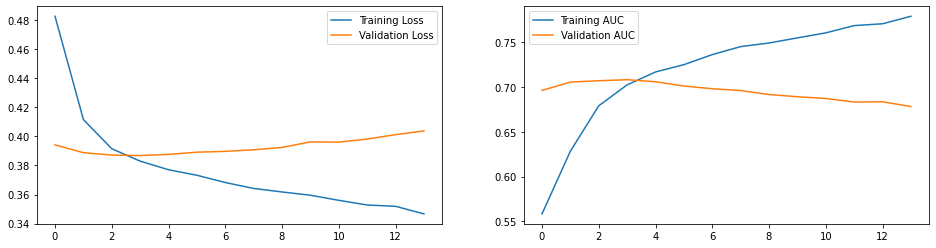

In [55]:
model_10, history_10 = nn_10(X_train, Y_train, X_test, Y_test)

In [97]:
# Changing Network Size - Adding more neurons --> 30, 15, 1

def nn_11(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(30,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 5s 5ms/step - loss: 0.4079 - auc_16: 0.6420 - val_loss: 0.3880 - val_auc_16: 0.7055
Epoch 2/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3810 - auc_16: 0.7091 - val_loss: 0.3910 - val_auc_16: 0.7049
Epoch 3/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3730 - auc_16: 0.7271 - val_loss: 0.3894 - val_auc_16: 0.7007
Epoch 4/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3662 - auc_16: 0.7430 - val_loss: 0.3942 - val_auc_16: 0.6968
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3599 - auc_16: 0.7564 - val_loss: 0.3984 - val_auc_16: 0.6889
Epoch 6/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3512 - auc_16: 0.7738 - val_loss: 0.4018 - val_auc_16: 0.6794
Epoch 7/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3453 - auc_16: 0.7842 - val_loss: 0.4112 - val_auc_16: 0.6768
Epoch 8/30
965/965 [==============

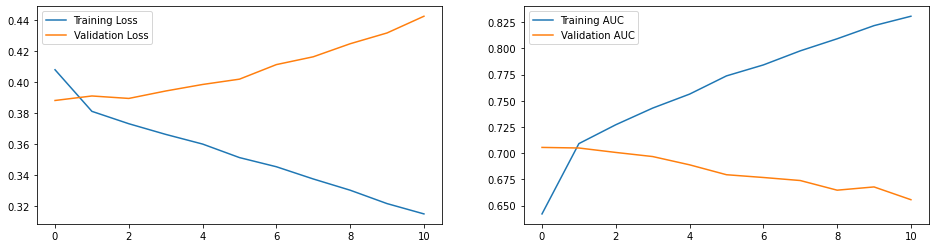

In [98]:
model_11, history_11 = nn_11(X_train, Y_train, X_test, Y_test)

In [99]:
# Changing Network Size - Adding more neurons --> 60, 30, 1

def nn_12(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(60,  activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3977 - auc_17: 0.6644 - val_loss: 0.3879 - val_auc_17: 0.7049
Epoch 2/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3779 - auc_17: 0.7149 - val_loss: 0.3879 - val_auc_17: 0.7044
Epoch 3/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3686 - auc_17: 0.7370 - val_loss: 0.3911 - val_auc_17: 0.7015
Epoch 4/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3589 - auc_17: 0.7580 - val_loss: 0.3960 - val_auc_17: 0.6938
Epoch 5/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3478 - auc_17: 0.7793 - val_loss: 0.4029 - val_auc_17: 0.6826
Epoch 6/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3362 - auc_17: 0.7986 - val_loss: 0.4097 - val_auc_17: 0.6746
Epoch 7/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3244 - auc_17: 0.8175 - val_loss: 0.4248 - val_auc_17: 0.6695
Epoch 8/30
965/965 [==============

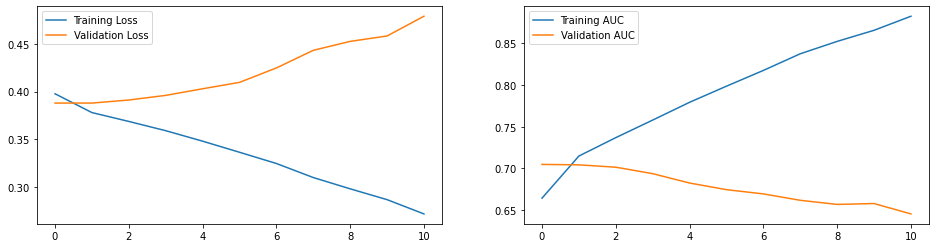

In [100]:
model_12, history_12 = nn_12(X_train, Y_train, X_test, Y_test)

In [101]:
# Changing Network Size - Adding more neurons --> 60, 30, 1, and increasing the dropout = 0.4

def nn_13(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(60,  activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 5s 5ms/step - loss: 0.4095 - auc_18: 0.6446 - val_loss: 0.3899 - val_auc_18: 0.7001
Epoch 2/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3845 - auc_18: 0.7022 - val_loss: 0.3869 - val_auc_18: 0.7083
Epoch 3/30
965/965 [==============================] - 4s 4ms/step - loss: 0.3800 - auc_18: 0.7139 - val_loss: 0.3891 - val_auc_18: 0.7034
Epoch 4/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3743 - auc_18: 0.7267 - val_loss: 0.3908 - val_auc_18: 0.6985
Epoch 5/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3679 - auc_18: 0.7398 - val_loss: 0.3912 - val_auc_18: 0.6969
Epoch 6/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3627 - auc_18: 0.7501 - val_loss: 0.3959 - val_auc_18: 0.6939
Epoch 7/30
965/965 [==============================] - 4s 5ms/step - loss: 0.3563 - auc_18: 0.7645 - val_loss: 0.3977 - val_auc_18: 0.6871
Epoch 8/30
965/965 [==============

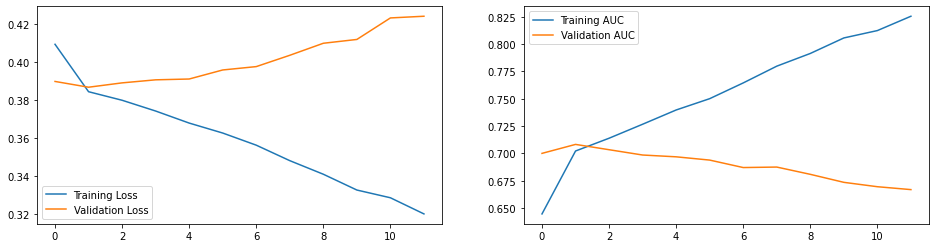

In [102]:
model_13, history_13 = nn_13(X_train, Y_train, X_test, Y_test)

In [103]:
# Keeping dropout high, adding regularization

def nn_14(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(60,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(30, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 6s 5ms/step - loss: 0.4480 - auc_19: 0.6487 - val_loss: 0.4123 - val_auc_19: 0.7042
Epoch 2/30
965/965 [==============================] - 5s 5ms/step - loss: 0.4078 - auc_19: 0.6869 - val_loss: 0.4021 - val_auc_19: 0.7083
Epoch 3/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3998 - auc_19: 0.6938 - val_loss: 0.3981 - val_auc_19: 0.7126
Epoch 4/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3958 - auc_19: 0.7010 - val_loss: 0.3975 - val_auc_19: 0.7132
Epoch 5/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3962 - auc_19: 0.6969 - val_loss: 0.3977 - val_auc_19: 0.7099
Epoch 6/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3946 - auc_19: 0.6992 - val_loss: 0.3960 - val_auc_19: 0.7117
Epoch 7/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3939 - auc_19: 0.6998 - val_loss: 0.3948 - val_auc_19: 0.7136
Epoch 8/30
965/965 [==============

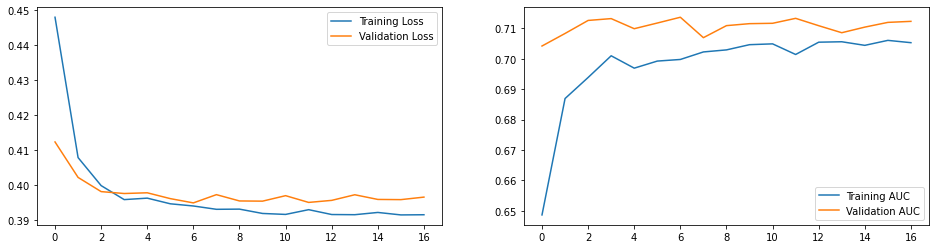

In [104]:
model_14, history_14 = nn_14(X_train, Y_train, X_test, Y_test)

In [105]:
# Increasing network size, keeping both regularization and dropout the same

def nn_15(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(100,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 6s 5ms/step - loss: 0.4533 - auc_20: 0.6581 - val_loss: 0.4162 - val_auc_20: 0.7044
Epoch 2/30
965/965 [==============================] - 5s 5ms/step - loss: 0.4062 - auc_20: 0.6951 - val_loss: 0.4043 - val_auc_20: 0.7043
Epoch 3/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3984 - auc_20: 0.6999 - val_loss: 0.3990 - val_auc_20: 0.7114
Epoch 4/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3953 - auc_20: 0.7022 - val_loss: 0.4006 - val_auc_20: 0.7058
Epoch 5/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3937 - auc_20: 0.7052 - val_loss: 0.4001 - val_auc_20: 0.7082
Epoch 6/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3934 - auc_20: 0.7054 - val_loss: 0.3997 - val_auc_20: 0.7087
Epoch 7/30
965/965 [==============================] - 5s 5ms/step - loss: 0.3940 - auc_20: 0.7025 - val_loss: 0.3972 - val_auc_20: 0.7085
Epoch 8/30
965/965 [==============

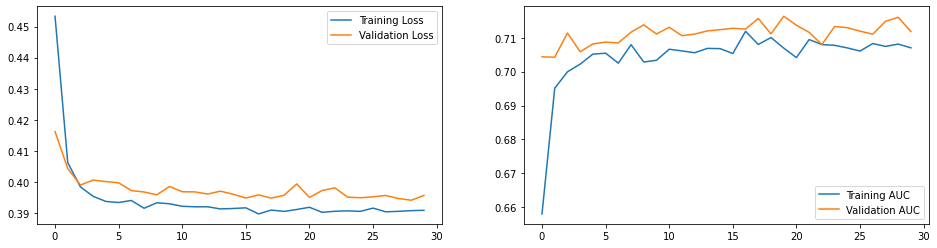

In [106]:
model_15, history_15 = nn_15(X_train, Y_train, X_test, Y_test)

In [107]:
# Increasing number of hidden layers, keeping regularization and dropout the same

def nn_16(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(100,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4843 - auc_21: 0.6389 - val_loss: 0.4249 - val_auc_21: 0.7057
Epoch 2/30
965/965 [==============================] - 5s 6ms/step - loss: 0.4195 - auc_21: 0.6774 - val_loss: 0.4062 - val_auc_21: 0.7084
Epoch 3/30
965/965 [==============================] - 5s 6ms/step - loss: 0.4057 - auc_21: 0.6904 - val_loss: 0.4026 - val_auc_21: 0.7113
Epoch 4/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4024 - auc_21: 0.6903 - val_loss: 0.4010 - val_auc_21: 0.7090
Epoch 5/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4002 - auc_21: 0.6944 - val_loss: 0.3995 - val_auc_21: 0.7077
Epoch 6/30
965/965 [==============================] - 5s 6ms/step - loss: 0.3985 - auc_21: 0.6947 - val_loss: 0.4033 - val_auc_21: 0.7058
Epoch 7/30
965/965 [==============================] - 5s 6ms/step - loss: 0.3976 - auc_21: 0.6975 - val_loss: 0.3995 - val_auc_21: 0.7074
Epoch 8/30
965/965 [==============

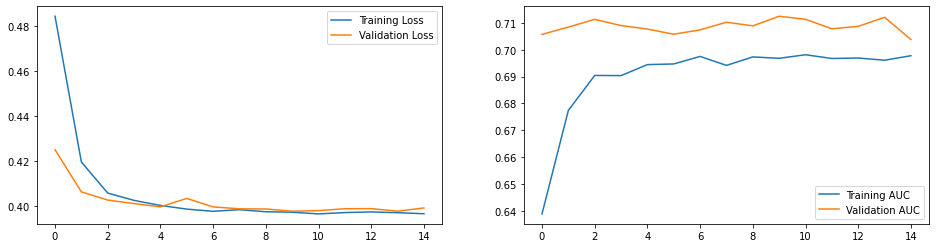

In [108]:
model_16, history_16 = nn_16(X_train, Y_train, X_test, Y_test)

In [109]:
# Same as above, but lowering the dropout

def nn_17(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(100,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4669 - auc_22: 0.6522 - val_loss: 0.4178 - val_auc_22: 0.6977
Epoch 2/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4081 - auc_22: 0.6914 - val_loss: 0.4034 - val_auc_22: 0.7089
Epoch 3/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3999 - auc_22: 0.6968 - val_loss: 0.3996 - val_auc_22: 0.7095
Epoch 4/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3969 - auc_22: 0.7005 - val_loss: 0.3989 - val_auc_22: 0.7095
Epoch 5/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3951 - auc_22: 0.7020 - val_loss: 0.3989 - val_auc_22: 0.7092
Epoch 6/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3940 - auc_22: 0.7029 - val_loss: 0.4000 - val_auc_22: 0.7017
Epoch 7/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3937 - auc_22: 0.7046 - val_loss: 0.3981 - val_auc_22: 0.7109
Epoch 8/30
965/965 [==============

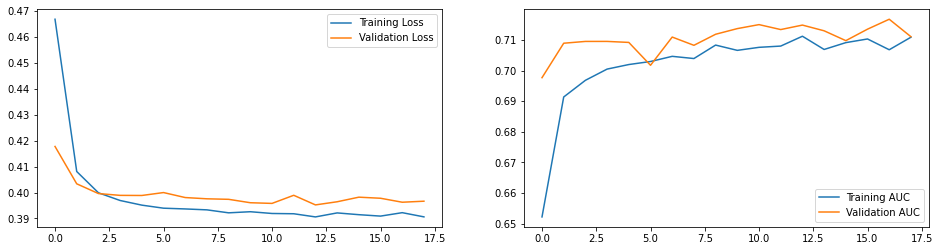

In [110]:
model_17, history_17 = nn_17(X_train, Y_train, X_test, Y_test)

In [113]:
# Doubling the network node size

def nn_18(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(200,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 7s 6ms/step - loss: 0.4901 - auc_24: 0.6701 - val_loss: 0.4206 - val_auc_24: 0.7023
Epoch 2/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4081 - auc_24: 0.6966 - val_loss: 0.4054 - val_auc_24: 0.7050
Epoch 3/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3975 - auc_24: 0.7042 - val_loss: 0.4032 - val_auc_24: 0.7093
Epoch 4/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3951 - auc_24: 0.7052 - val_loss: 0.4008 - val_auc_24: 0.7107
Epoch 5/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3948 - auc_24: 0.7025 - val_loss: 0.3996 - val_auc_24: 0.7101
Epoch 6/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3933 - auc_24: 0.7071 - val_loss: 0.3996 - val_auc_24: 0.7093
Epoch 7/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3933 - auc_24: 0.7068 - val_loss: 0.4016 - val_auc_24: 0.7103
Epoch 8/30
965/965 [==============

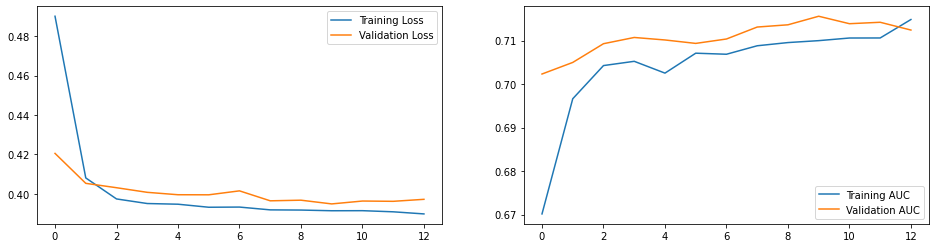

In [114]:
model_18, history_18 = nn_18(X_train, Y_train, X_test, Y_test)

In [115]:
# Doubling Regularization

def nn_19(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(200,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 7s 6ms/step - loss: 0.5081 - auc_25: 0.6692 - val_loss: 0.4201 - val_auc_25: 0.6996
Epoch 2/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4073 - auc_25: 0.6872 - val_loss: 0.4039 - val_auc_25: 0.7074
Epoch 3/30
965/965 [==============================] - 6s 6ms/step - loss: 0.4008 - auc_25: 0.6957 - val_loss: 0.4019 - val_auc_25: 0.7080
Epoch 4/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3999 - auc_25: 0.6938 - val_loss: 0.4014 - val_auc_25: 0.7059
Epoch 5/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3988 - auc_25: 0.6946 - val_loss: 0.4047 - val_auc_25: 0.7042
Epoch 6/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3983 - auc_25: 0.6966 - val_loss: 0.4013 - val_auc_25: 0.7065
Epoch 7/30
965/965 [==============================] - 6s 6ms/step - loss: 0.3986 - auc_25: 0.6946 - val_loss: 0.4014 - val_auc_25: 0.7063
Epoch 8/30
965/965 [==============

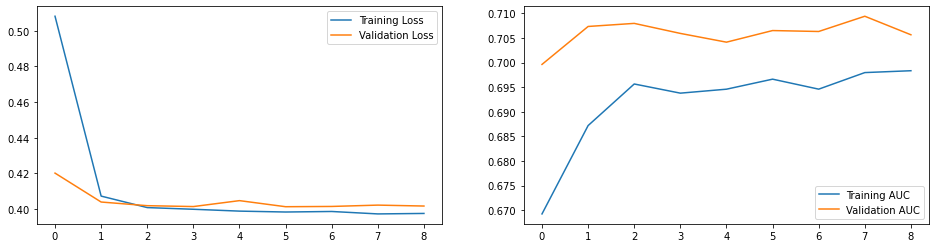

In [116]:
model_19, history_19 = nn_19(X_train, Y_train, X_test, Y_test)

In [117]:
# Increasing network size and adding one more layer

def nn_20(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(Dense(500,  activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.002)))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])
    
    history_dict = history.history
    history_dict.keys()
    history_df = pd.DataFrame(history_dict)
    history_df.tail(10).round(3)
    key_list = list(history.history.keys())
    losses = history.history[key_list[0]]
    accs = history.history[key_list[1]]
    val_losses = history.history[key_list[2]]
    val_accs = history.history[key_list[3]]
    epochs = len(losses)

    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'AUC'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

    return model, history

Epoch 1/30
965/965 [==============================] - 8s 7ms/step - loss: 0.5763 - auc_26: 0.6651 - val_loss: 0.4173 - val_auc_26: 0.7026
Epoch 2/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4099 - auc_26: 0.6861 - val_loss: 0.4131 - val_auc_26: 0.7060
Epoch 3/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4041 - auc_26: 0.6929 - val_loss: 0.4068 - val_auc_26: 0.7032
Epoch 4/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4035 - auc_26: 0.6913 - val_loss: 0.4048 - val_auc_26: 0.7104
Epoch 5/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4027 - auc_26: 0.6906 - val_loss: 0.4052 - val_auc_26: 0.7082
Epoch 6/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4012 - auc_26: 0.6938 - val_loss: 0.4041 - val_auc_26: 0.7062
Epoch 7/30
965/965 [==============================] - 6s 7ms/step - loss: 0.4018 - auc_26: 0.6921 - val_loss: 0.4051 - val_auc_26: 0.7041
Epoch 8/30
965/965 [==============

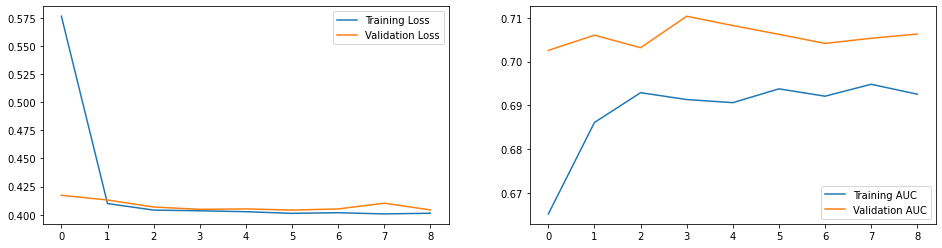

In [118]:
model_20, history_20 = nn_20(X_train, Y_train, X_test, Y_test)

In [125]:
# Find the best model run val_auc

def get_best_val_aucs(n_runs):    
    best_val_aucs = []
    for i in range(1, n_runs):
        try:
            temp = eval('history_' + str(i) + '.history[list(history_' + str(i) + '.history.keys())[-1]][-1]')
            print("Run", str(i), ":", round(temp, 4))
        except:
            continue
        best_val_aucs.append(round(temp, 4))
    print("Best Run was: ", best_val_aucs.index(max(best_val_aucs)) + 1, ", AUC: ", max(best_val_aucs))
    return

get_best_val_aucs(22)

Run 1 : 0.6936
Run 2 : 0.7054
Run 3 : 0.7061
Run 4 : 0.687
Run 5 : 0.6877
Run 6 : 0.7001
Run 7 : 0.6938
Run 8 : 0.6678
Run 9 : 0.6607
Run 10 : 0.678
Run 11 : 0.6555
Run 12 : 0.6456
Run 13 : 0.6669
Run 14 : 0.7123
Run 15 : 0.7118
Run 16 : 0.7038
Run 17 : 0.711
Run 18 : 0.7124
Run 19 : 0.7057
Run 20 : 0.7063
Best Run was:  18 , AUC:  0.7124


#### Interpretability

Check the interpretability of the models to see what is happening.

In [160]:
import shap
shap.__version__

'0.39.0'

In [227]:
explainer = shap.Explainer(model_18.predict, X_train.iloc[0:100])
shap_values_x = explainer(X_test.iloc[0:25])

Permutation explainer: 26it [04:11, 10.05s/it]                                                                         


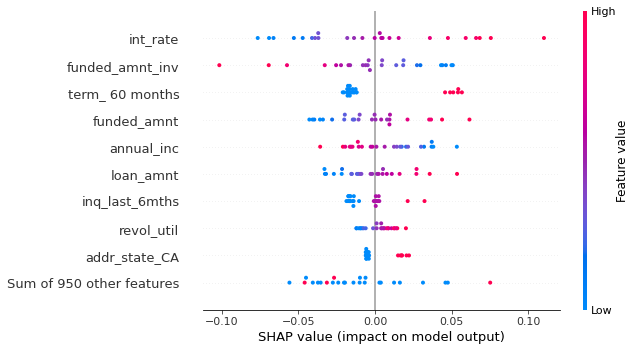

In [228]:
shap.plots.beeswarm(shap_values_x)

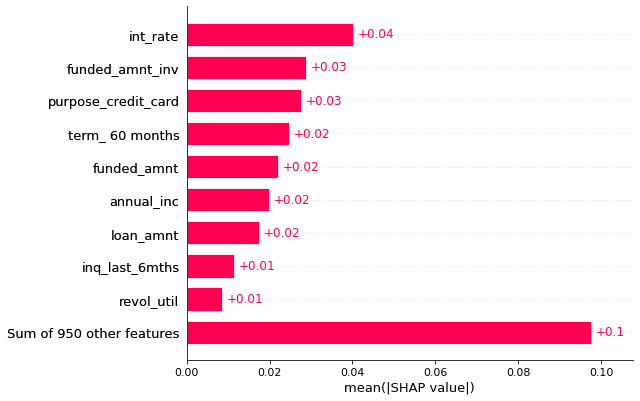

In [229]:
shap.plots.bar(shap_values_x)

In [236]:
explainer_k = shap.KernelExplainer(model_18.predict, X_train.iloc[0:100])
shap_values_k = explainer_k.shap_values(X_test.iloc[0:25])

  0%|          | 0/25 [00:00<?, ?it/s]

Permutation explainer:  36%|█████████████████████▌                                      | 9/25 [04:44<09:29, 35.62s/it]


In [237]:
shap.initjs()
shap.force_plot(explainer_k.expected_value[0], shap_values_k[0], X_test)